In [ ]:
import os
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage.interpolation import rotate
from scipy.ndimage.filters import gaussian_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from tensorboardX import SummaryWriter
from torchvision import transforms

from resnet import resnet18
from radam import RAdam

In [ ]:
root='./rebuild_dataset'
sz = np.load(f'{root}/sz_oleg.npz')['sz_data'].astype(np.float32)
print('sz.shape', sz.shape)
wo_sz = np.load(f'{root}/wo_sz_oleg.npz')['sz_data'].astype(np.float32)
print('wo_sz.shape', wo_sz.shape)

In [ ]:
def train_val_test_split(data, val_size=0.15, test_size=0.15, random_state=9):
    assert val_size + test_size < 1
    val_test_size = val_size + test_size
    test_relative_size = test_size / val_test_size
    
    indices = range(data.shape[0])
    train_indices, test_indices = train_test_split(indices, test_size=val_test_size, random_state=random_state)
    val_indices, test_indices = train_test_split(test_indices, test_size=test_relative_size,
                                                 random_state=random_state)
    
    return data[train_indices], data[val_indices], data[test_indices]
  

def crop_center_or_pad(img, new_side):
    _, y, x = img.shape
    if x > new_side:
        startx = x//2-(new_side//2)
        return img[:, startx:startx+new_side,startx:startx+new_side]
    elif x < new_side:
        padx = (new_side//2) - x//2
        return np.pad(img, ((0,), (padx,), (padx,)), mode='constant', constant_values=-1)
    return img

#simple image scaling to (nR x nC) size
def scale_nearest(im, nR, nC):
    nR0 = len(im)     # source number of rows 
    nC0 = len(im[0])  # source number of columns 
    return np.array([[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)])


In [ ]:
class Planck(Dataset):
    frequencies = ['100', '143', '217', '353', '545']
    
    def __init__(self, sz, wo_sz, split='None'):
        self.is_train = split == 'train'
        
        # 70/15/15
        sz_train, sz_val, sz_test = train_val_test_split(sz)
        wosz_train, wosz_val, wosz_test = train_val_test_split(wo_sz)
        
        if split == 'train':
            self.X = np.concatenate((sz_train, wosz_train), axis=0)
            self.y = np.array([1] * sz_train.shape[0] + [0] * wosz_train.shape[0], dtype=np.uint8)
        elif split == 'val':
            self.X = np.concatenate((sz_val, wosz_val), axis=0)
            self.y = np.array([1] * sz_val.shape[0] + [0] * wosz_val.shape[0])
        elif split == 'test':
            self.X = np.concatenate((sz_test, wosz_test), axis=0)
            self.y = np.array([1] * sz_test.shape[0] + [0] * wosz_test.shape[0], dtype=np.uint8)
        else:
            raise Exception()
            
#         for i in range(5):
#             self.X[:, i] = (self.X[:, i] - np.mean(self.X[:, i])) / np.std(self.X[:, i])

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
#         print(X.shape, X.size)

        if self.is_train:
            angle = np.random.randint(0, 360)
            x_shift, y_shift = np.random.randint(-31, 32), np.random.randint(-31, 32)
            scale = float(np.random.randint(90, 120)) / 100
            
            X = np.pad(X, ((0,), (32,), (32,)), mode='constant', constant_values=-1)
            X = np.roll(X, x_shift, axis=0)
            X = np.roll(X, y_shift, axis=1)
            X = rotate(X, angle, axes=(1, 2), reshape=False, mode='constant', cval=-1)
            
#             target_dim = int(X.shape[1] * scale)
#             X = np.array([scale_nearest(X[i], target_dim, target_dim) for i in range(5)])
            X = crop_center_or_pad(X, 256)

#         X = np.array([gaussian_filter(X[i], sigma=3) for i in range(5)])
        
        X = X[:, ::2, ::2]
        X = crop_center_or_pad(X, 128)
        return torch.from_numpy(X), y

# Train

In [ ]:
batch_size = 50

train_dataset, val_dataset = Planck(sz, wo_sz, split='train'), Planck(sz, wo_sz, split='val')
print(len(train_dataset))
print(len(val_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
img_effect_1, answer_sz_1 = train_dataset.__getitem__(1)
img_effect_2, answer_sz_2 = train_dataset.__getitem__(5)
img_no_effect_1, answer_wo_sz_1 = train_dataset.__getitem__(1201)
img_no_effect_2, answer_wo_sz_2 = train_dataset.__getitem__(1205)

assert(answer_sz_1 and answer_sz_2 and not answer_wo_sz_1 and not answer_wo_sz_2)

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i in range(5):
    ax[0][i].imshow(img_effect_1[i])
    ax[1][i].imshow(img_effect_2[i])
    ax[2][i].imshow(img_no_effect_1[i])
    ax[3][i].imshow(img_no_effect_2[i])

In [ ]:
def accuracy_sc(y_pred, y_true, threshold=0.5):
    return accuracy_score((y_pred.detach().cpu().numpy() > threshold).astype(np.uint8), y_true.cpu().numpy())

def f1_sc(y_pred, y_true, threshold=0.5):
    return f1_score((y_pred.detach().cpu().numpy() > threshold).astype(np.uint8), y_true.cpu().numpy())

In [ ]:
device = 'cuda:0'
name = 'v2_128_oleg_14'
n_epochs = 250

# try:
os.mkdir(f'./checkpoints/{name}')
# except Exception as e:
#     print(e)

In [ ]:
model = resnet18(num_classes=1).to(device)
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = RAdam(model.parameters(), lr=0.0003)
scheduler = StepLR(optimizer, step_size=90, gamma=0.2)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
writer = SummaryWriter(logdir=f'./logs/{name}')

best_val_loss = np.inf
for epoch in tqdm(range(n_epochs)):
    model.train()
    for idx, batch in enumerate(train_dataloader):
        X, y_true = batch
        X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)

        optimizer.zero_grad()

        y_pred = model(X)

        loss = criterion(y_pred, y_true)
        loss.backward()

        optimizer.step()
        
        loss = loss.detach()
        acc = accuracy_sc(y_pred, y_true)
        f1 = f1_sc(y_pred, y_true)
        
        writer.add_scalar('train/loss', loss, epoch * len(train_dataloader) + idx)
        writer.add_scalar('train/acc', acc, epoch * len(train_dataloader) + idx)
        writer.add_scalar('train/f1', f1, epoch * len(train_dataloader) + idx)
        writer.file_writer.flush()
    
    with torch.no_grad():
        model.eval()
        val_loss, val_acc, val_f1, steps = 0, 0, 0, 0
        for idx, batch in enumerate(val_dataloader):
            X, y_true = batch
            X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)

            y_pred = model(X)

            loss = criterion(y_pred, y_true)

            val_loss += loss.detach()
            val_acc += accuracy_sc(y_pred, y_true)
            val_f1 += f1_sc(y_pred, y_true)
            steps += 1
            
        val_loss /= steps
        val_acc /= steps
        val_f1 /= steps
        
        writer.add_scalar('val/loss', val_loss, epoch)
        writer.add_scalar('val/acc', val_acc, epoch)
        writer.add_scalar('val/f1', val_f1, epoch)
        writer.file_writer.flush()
        
    scheduler.step()
    writer.add_scalar('train/lr', scheduler.get_lr(), epoch)
        
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'./checkpoints/{name}/net_{epoch}.pt')
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./checkpoints/{name}/net_best.pt')
        best_val_loss = val_loss
    torch.save(model.state_dict(), f'./checkpoints/{name}/net_last.pt')

# Find threshold of best model

In [15]:
name = 'v2_128_oleg_14'

In [16]:
best_checkpoint_name = f'./checkpoints/{name}/net_best.pt'
model.load_state_dict(torch.load(best_checkpoint_name))
model.eval();

In [20]:
best_t, best_acc = 0, 0
all_t, all_acc = [], []
for t in np.linspace(0, 1, 101):
    steps, test_acc = 0, 0.
    for idx, batch in enumerate(val_dataloader):
        X, y_true = batch
        X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)
        y_pred = torch.sigmoid(model(X))

        steps += 1
        test_acc += accuracy_sc(y_pred, y_true, threshold=t)
    test_acc /= steps
    print(f'{t:.2f}, {test_acc:.3f}')
    all_t.append(t)
    all_acc.append(test_acc)
    if test_acc > best_acc:
        best_t, best_acc = t, test_acc
print(f'best {best_t:.2f}, acc: {best_acc:.3f}')

0.00, 0.429
0.01, 0.466
0.02, 0.511
0.03, 0.537
0.04, 0.571
0.05, 0.591
0.06, 0.609
0.07, 0.617
0.08, 0.634
0.09, 0.640
0.10, 0.649
0.11, 0.649
0.12, 0.660
0.13, 0.666
0.14, 0.674
0.15, 0.671
0.16, 0.674
0.17, 0.677
0.18, 0.677
0.19, 0.680
0.20, 0.683
0.21, 0.686
0.22, 0.686
0.23, 0.689
0.24, 0.686
0.25, 0.686
0.26, 0.686
0.27, 0.686
0.28, 0.683
0.29, 0.683
0.30, 0.689
0.31, 0.694
0.32, 0.697
0.33, 0.703
0.34, 0.706
0.35, 0.709
0.36, 0.711
0.37, 0.714
0.38, 0.860
0.39, 0.866
0.40, 0.866
0.41, 0.863
0.42, 0.863
0.43, 0.863
0.44, 0.863
0.45, 0.863
0.46, 0.863
0.47, 0.863
0.48, 0.863
0.49, 0.863
0.50, 0.866
0.51, 0.866
0.52, 0.866
0.53, 0.866
0.54, 0.869
0.55, 0.869
0.56, 0.863
0.57, 0.866
0.58, 0.866
0.59, 0.863
0.60, 0.863
0.61, 0.863
0.62, 0.863
0.63, 0.860
0.64, 0.857
0.65, 0.854
0.66, 0.860
0.67, 0.857
0.68, 0.857
0.69, 0.849
0.70, 0.846
0.71, 0.846
0.72, 0.846
0.73, 0.851
0.74, 0.851
0.75, 0.851
0.76, 0.849
0.77, 0.840
0.78, 0.840
0.79, 0.840
0.80, 0.846
0.81, 0.846
0.82, 0.843
0.83

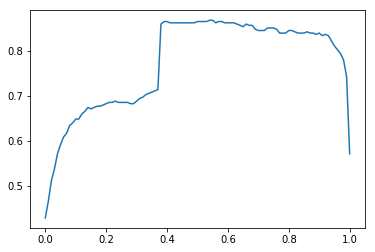

In [21]:
plt.plot(all_t, all_acc)

In [25]:
best_t = 0.4

# Apply on test with best theshold

In [26]:
test_dataset = Planck(sz, wo_sz, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [27]:
for t in [0.5, best_t]:
    steps, test_acc = 0, 0
    for idx, batch in enumerate(test_dataloader):
        X, y_true = batch
        X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)
        y_pred = model(X)

        steps += 1
        test_acc += accuracy_sc(y_pred, y_true, threshold=best_t)
    test_acc /= steps

    print(f'{t:.2f}, acc: {test_acc:.3f}')

0.50, acc: 0.805
0.40, acc: 0.805


# Apply (with load chckpoint)

In [28]:
name = 'v2_128_oleg_14'
checkpoint_name = f'./checkpoints/{name}/net_best.pt'  # './checkpoints/try_bce6/net_best.pt'
threshold = 0.4
model.load_state_dict(torch.load(checkpoint_name, map_location=torch.device('cpu')))
model.eval();

In [29]:
steps, test_acc = 0, 0
recall_steps, test_recall = 0, 0
for idx, batch in enumerate(test_dataloader):
    X, y_true = batch
    X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)
    y_pred = torch.sigmoid(model(X))

    steps += 1
    test_acc += (y_pred.item() > threshold) == y_true.item()
    if y_true.item() == 1:
        recall_steps += 1
        test_recall += (y_pred.item() > threshold) == y_true.item()
test_acc /= steps
test_recall /= recall_steps

print(f'acc: {test_acc:.3f}')
print(f'recall: {test_recall:.3f}')

acc: 0.801
recall: 0.813


In [ ]:
test_recall

In [ ]:
torch.sigmoid(y_pred.detach()).item()

In [ ]:
y_pred.item()